## Introduction ##
Welcome to the sequencing technologies module! In lecture this week, we talked about some of the most common sequencing methods (e.g. Sanger, Illumina) and the steps you may need to take to process or cleanup sequencing data. 

In this module, we'll be exploring a sample FASTQ file and conducting some basic analyses. Our goal is to get the gene count from a file containing sequencing data. Make sure to run all of the cells!

## Setup ##
We'll need [Biopython](https://biopython.org), a set of computational biology and bioinformatics tools for Python. Biopython includes handy tools for sequence alignment, structural biology analyses, and more. If you want Biopython on your local machine and you already have Python installed, try running `pip install biopython`. 

Run the cell below to import useful libraries.

In [ ]:
#import some other handy data analysis tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Part 1: Sequencing Data - FASTQ Files ##
As mentioned in lecture, FASTQ files are a file format used to store sequences data and PHRED quality scores. We've provided a sample FASTQ file called `s_cere_reads.fastq` (RNA-seq reads from the yeast *S. cerevisiae*). Let's look at the first record, which stores data for one read. As a reminder, this is what the lines in a FASTQ file mean: ![Fastq](fastq.png)


In [ ]:
with open('s_cere_reads.fastq', 'r') as f:
  for i in range(4):
    print(f.readline())

Now, we're curious how many records are in this file. 

`SeqIO.parse()` returns an iterator of `SeqRecord` objects. Biopython uses an iterator instead of an array or set when reading files due to potentially large file sizes. FASTQ and FASTA files can go up to the GB range! Luckily, our FASTQ file isn't huge and we can safely store all the objects in an array.

**QUESTION 1**: How many records are in this file? Play with the cell below to find out. 

Your answer here: 85046

In [1]:
from Bio import SeqIO
from Bio import AlignIO

records = []
records_iter = SeqIO.parse('s_cere_reads.fastq', "fastq")
for record in records_iter:
  records.append(record)
count = len(records)
print(count)

85046


Now we have all our records Let's peek at the first element to see what a `SeqRecord` object looks like.

In [ ]:
rec_0 = records[0]
print(rec_0)

## Part 2: Quality Control ##
One of the first steps after obtaining sequencing data is usually quality control. No sequencing method is perfect, and we want to know if we can be confident in our data.

Let's look at the PHRED quality scores of the first record. The PHRED quality scores of a `SeqRecord` object can be accessed with `.letter_annotations["phred_quality"]`.

In [ ]:
phred_scores = rec_0.letter_annotations["phred_quality"]
print(phred_scores)

**QUESTION 2a**: What is the average PHRED quality score of all the bases in `rec_0`? Look back at the table provided in lecture, what is the approximate accuracy of this read data?

In [5]:
first_record = records[0]
phred_scores = first_record.letter_annotations["phred_quality"]
mean = sum(phred_scores) / len(phred_scores)
print(mean)

37.45333333333333


Q2A Answer Here: The average PHRED quality score is 37.5. The approximate accuracy of this read data is between 99.9 to 99.99% accurate, meaning that it is a very good prediction of the average PHRED quality score.

Getting the average of the data only tells us one part of the story. Now, we will create a histogram of the PHRED scores so we can see a distribution of the data! 

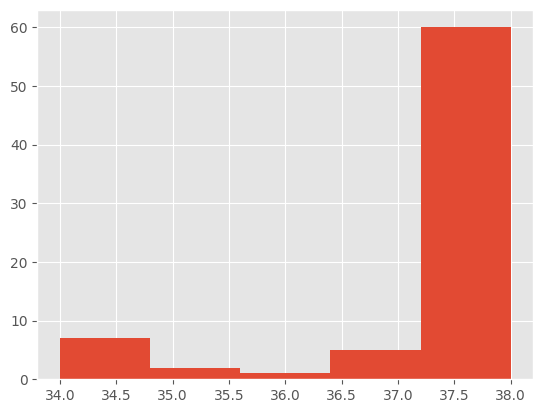

In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.hist(phred_scores, bins=5)
plt.show()

**QUESTION 2b**: Please describe the distribution here. Is it normal, is it skewed, etc.? Also, describe the range and if you think this data is low quality, medium quality, or high quality and why?

Q2B Answer here: The distribution presented by the histogram of the PHRED scores is heavily skewed to the right, since a majority of the scores are on the right side of the graph, especially in the 37.5 to 38 score region. Though the data ranges across the entirety of the histogram, a majority of the scores lie in the far right side of it. Given that the data is so heavily skewed, it may seem that the data is of low quality, but in my opinion, the data is of high quality since, as shown in the table from lecture, data points in the 30 to 40 range have an extremely high accuracy that ranges between 99.9 to 99.99 percent accurate, which is an indiciation of good data quality.

# Read Trimming

As mentioned in lecture, the next step after quality control is to trim the reads that are not up to par with our quality levels. Usually, this consists of reads that have a PHRED score of 20 or below. Since our records do not have a PHRED score of less than 20 as seen from the histogram, we will move on from this step for now. Note that we've just looked at one of the reads; in real applications you'll want to filter all reads.

**QUESTION 2c**: Write code that loops over all of the records, finds the average PHRED score in each record, and plots the averages as a histogram. What observations can you make about the average PHRED scores? (Note that since you're looping over 25,000 records, your code might take some time to run)

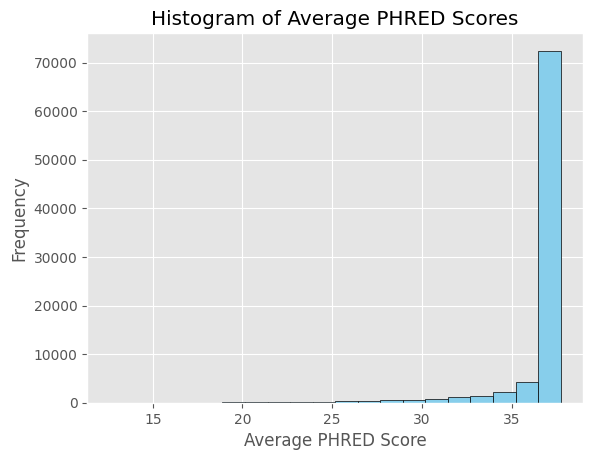

In [8]:
# 1) Loop over all records
# 2) Find the average PHRED score in each record
# 3) Plot the averages as histogram
# Write your code here!

import matplotlib.pyplot as plt
from Bio import SeqIO
average_scores = []
for record in records:
    phred_scores = record.letter_annotations["phred_quality"]
    average_score = sum(phred_scores) / len(phred_scores)
    average_scores.append(average_score)
plt.hist(average_scores, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Average PHRED Score')
plt.ylabel('Frequency')
plt.title('Histogram of Average PHRED Scores')
plt.show()

Q2C Answer here: Through this histogram, I was able to observe that none of the average PHRED scores fall below the range of 18 to 19, and that the histogram is primarily skewed to the right, meaning that a majority of the scores are between 35 to 40, as it has the highest frequency. Based on all of these observations, I can infer that of all the 25,000 records, most of them have a PHRED score between 35 to 40. Based on the table provided in lecture, they have an accuracy of around 99.99%, which means that the data is extremely accurate and of good quality.

# Data Exploration

Before we move on to alignment, let's convert our fastq file to the FASTA format to analyze and understand the data we're dealing with more.

In [ ]:
from Bio import SeqIO
with open("s_cere_reads.fastq", "r") as input_handle, open("s_cere_reads.fasta", "w") as output_handle:
    sequences = SeqIO.parse(input_handle, "fastq")        
    count = SeqIO.write(sequences, output_handle, "fasta")        
print("Converted %i records" % count)

Now that we have our file in FASTA format under the name `s_cere_reads.fasta`, let's explore some basic genome properties of our first read.

In [ ]:
records_fa = []
records_iter_fa = SeqIO.parse('s_cere_reads.fasta', "fasta")
for record in records_iter_fa:
  # Don't change this line! We're adding all elements of the 
  # iterator into an array we can work with.
  records_fa.append(record)

In [ ]:
rec_1 = records[0]
print(rec_1)

In [ ]:
print(rec_1.seq)

In [ ]:
print("Sequence length (bp)", len(rec_1))

As you can see this read has a sequence length of ~75bp which means it is a short read. This means that when aligning, we now know to use an aligner that is best for short-reads. 

***Note***: For now, we have looked at only 1 read, a more accurate representation would be to create a histogram of sequence length for each read so we can get an idea for the average read length rather than from a single record.

## Part 3: Alignment

Alright, now that we have explored our data and have come to the conclusion that we have a short-read sequencing set, we will move on to aligning our data to a reference genome! As mentioned in lecture, aligning reads is like putting puzzle pieces together according to a reference picture. The other option we could take is to do assembly, however that is much more time-consuming and best used if we do not have a reference genome. 

Our reference genome will be the `S. cerevisiae` genome. As for our aligner, we will be using `Bowtie2`, as this is very efficient for short-read alignment.

In order for `Bowtie2` to work, we need to provide it with trimmed reads files and an *index* of the reference genome. We have included this index in the files with this module; you can download indices for other organisms in the sidebar of [Bowtie2's website](http://bowtie-bio.sourceforge.net/bowtie2/index.shtml).


In [ ]:
# The following line runs the Bowtie2 command
# Bowtie2 is preinstalled on the biology datahub computer.
!bowtie2 -x s_cere/s_cere -U s_cere_reads.fastq -S output.sam

Let's take apart that command piece-by-piece:
- First, we used the `!` symbol. This is a Jupyter-specific symbol (i.e. it won't work in regular Python) that allows us to run commands *on the command line*. Bowtie2 is an executable program that's usually run from a command line.
- The `-x s_cere/s_cere` portion tells Bowtie2 the location of the *indices* which it uses to align reads. These are in the form of `.bt2` files, which are included in a folder imported with this module.
- The `-U s_cere_reads.fastq` portion tells Bowtie2 the location of the FASTQ file we've been using.
- The `-S output.sam` portion tells Bowtie2 the name we want to give to the output SAM file. This is a type of file often used to represent alignments.

Note also in the output the number of alignments. You should have a high overall alignment rate; unusually low rates may indicate an error, such as low-quality reads or an incorrect index

Let's take a look at this SAM file:

In [10]:
with open("output.sam", 'r') as f:
  for i in range(25):
    print(f.readline())

FileNotFoundError: [Errno 2] No such file or directory: 'output.sam'

We can see that this file starts off with several lines of metadata, followed by a tab-separated table. You may recognize some of the fields of the table from the FASTQ files; to learn more about the SAM format for storing alignments, you can look at the [file specification](http://samtools.github.io/hts-specs/). 

**QUESTION 3**: According to the specification, what do the columns in the table represent? What does the first line in the header mean?

Q3 Answer here: According to the specification, the columns in the table represent different pieces of information regarding the alignments, which makes it easier for an individual to understand key details regarding a certain alignment. The first line in the header displays the alignment's file format and reference sequence.

# Part 4: Gene Counts

Now that we've produced an alignment, the next step is to count each of the reads mapping to each gene. To do this, we will need two things:
1. An alignment, which we have as the SAM file output from Bowtie2.
2. A genome annotation file. The most commonly used file type is a GFF file (you may also see a GTF file; these are identical to version 2 of the GFF specification). These files contain information about the start and end position of each gene, as well as other annotations. 

In our case, we've provided the file `sacCer3.ensGene.gtf` for genome annotations of the *S. cerevisiae* genome, which was downloaded from the [UCSC Genome Browser page](http://hgdownload.soe.ucsc.edu/downloads.html). Let's see what this file looks like:

In [ ]:
with open("sacCer3.ensGene.gtf") as f:
  for i in range(5):
    print(f.readline())

We can see that we have another tab-delimited table of values.

**QUESTION 4a**: Look up the GTF file specification. What do each of the columns mean? What does the first line of the annotation mean?

Q4a Answer here: In the GTF file specification, each of the columns represents the Seqname, source, feature, start, end, score, strand, frame, and attribute, all of which hold information related to the genomic features of a specific genome. The first line of the annotation represents the purpose of a genome annotation file, as well as relevant details to the file, such as genetic indentification, name, source, biotype, and other pertinent data or sources.  

In order to find gene counts, we'll be using the package `HTSeq`. We can install the package with the line below:

In [ ]:
!pip install pysam htseq

`HTSeq` is once again run from the command line; we can run it with our files as follows:

In [ ]:
!htseq-count output.sam sacCer3.ensGene.gtf > s_cere_counts.tsv

In this command, the program we are running is `htseq-count`. The two arguments are our alignment (`output.sam`) and the annotation (`sacCer3.ensGene.gtf`). We then use a *redirect character* (`>`) to send the output of the command to a file, `s_cere_counts.tsv`.

We can view the contents of this TSV file as follows:

In [ ]:
with open("s_cere_counts.tsv") as f:
  for i in range(5):
    print(f.readline())

This file has two columns: the first is the gene name, and the second is the count for that gene. 

**QUESTION 4b**: Use pandas to read in the count data (*hint:* remember the `pd.read_csv()` function) and make a barplot for the genes that have nonzero counts. What do you notice about the output, and why might this be the case?

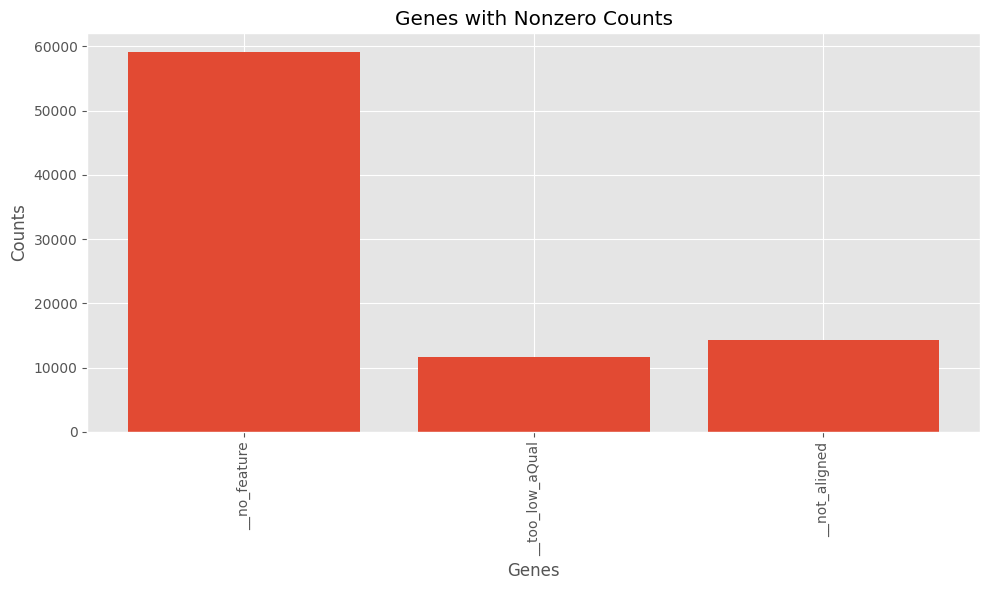

In [11]:
# Write your code here
import pandas as pd
import matplotlib.pyplot as plt
count_data = pd.read_csv("s_cere_counts.tsv", sep="\t", header=None, names=["Gene", "Count"])
nonzero_counts = count_data[count_data["Count"] > 0]
plt.figure(figsize=(10, 6))
plt.bar(nonzero_counts["Gene"], nonzero_counts["Count"])
plt.xlabel("Genes")
plt.ylabel("Counts")
plt.title("Genes with Nonzero Counts")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Q4b Answer here: Based on the barplot I created for genes that have nonzero counts, I noticed in the output that genes that had no feature had the highest count, with it being around 60,000. On the other hand,genes with lower quality or that were not aligned were significantly lower in count, ranging between 10,000 to 20,000. I think this outcome might be the case because there might be differences in the level of gene expression amongst various genes, which could be depe

Congrats on finishing this module!